# Stat-Win Correlation analysis: Team stat

> by Imt of NYXL (imt@andbox.com)

# Data Preparation

In [22]:
import os
import pandas as pd 
import numpy as np
from tqdm import tqdm
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_ind_from_stats

## 0. Preprocess simple PHS files

> define `is_all_time` == True or False

> if `is_all_time` == False, then specify `phs_name = phs_list[#]`

> add `is_match_winner` and `is_map_winner` features into the dataframe

In [2]:
# File path of prepared new_phs
path = "./data/"
phs_list = os.listdir(path)
phs_list = [file_name for file_name in phs_list if file_name.endswith(".csv")]

# choose all time or specific season
is_all_time = False # set True if target data is all seasons data

if is_all_time == True:
    li = []
    for phs_name in phs_list:
        new_phs = pd.read_csv(f'{path}{phs_name}')
        li.append(new_phs)
    new_phs = pd.concat(li, axis=0, ignore_index=True)
    all_seasons = True

else:
    phs_name = phs_list[11] # set index of target csv file
    print(f'selected phs: {phs_name}')
    new_phs = pd.read_csv(f'{path}{phs_name}')
    all_seasons = False

# Add 'is_match_winner' feature
def match_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0
    '''
    if df['match_winner'] == df['team_name']: #there's 'team' column in 2018 data 
        return 1
    elif df['match_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_match_winner'] = new_phs.apply(match_winner, axis = 1)

# Add 'is_map_winner' feature
def map_winner(df):
    '''
    args, get a dataframe, expected to be phs with selected features
    targets, winner = 1; loser = 0; draw = -1
    '''
    if df['map_winner'] == df['team_name']:
        return 1
    elif df['map_winner'] == 'draw':
        return -1
    else:
        return 0

new_phs['is_map_winner'] = new_phs.apply(map_winner, axis = 1)

selected phs: new_phs_2020_2.csv


## 1. Feature Engineering

> define a `target_hero` = <hero name>

> remove features of `remove_feature`

> specify the data type `X, y = data_type[#]` among 0:'real', 1:'norm' or 2:'10min avg' ...

In [3]:
# data collection
df = new_phs[['esports_match_id', 'player_name', 'team_name', 'map_name', 'stat_name', 'hero_name', 'stat_amount', 'is_map_winner']]

# select target hero
'''
지금 양팀 모두 같은 영웅을 쓴 것 아니면 normalize 에서 같이 비교하기 힘들다
'''
target_hero = 'All Heroes' # put 'All Heroes' for selecting all heroes

# data selection
df = df[df['hero_name'] == target_hero]
df['is_map_winner'].dropna(axis=0, inplace=True) # drop nan values
df.drop(df[df['is_map_winner'] == -1].index , inplace=True) # drop draw

df = df.groupby(['esports_match_id', 'player_name', 'is_map_winner', 'map_name', 'stat_name'])[['stat_amount', 'is_map_winner']].mean()
df = df.unstack()

df = df.xs('stat_amount', level=0, axis=1)

# Remove irrelevant features
remove_feature = ['Average Time Alive', 'Damage Done', 'Knockback Kills', 'Teleporter Pads Destroyed', 'Time Alive', 'Turrets Destroyed', 'Ultimates Earned - Fractional'] # Always remove these features
remove_feature.extend([]) # remove features seems to be irrelevant or redundant
df = df[df.columns.difference(remove_feature)]

# Data cleansing
df.fillna(0, inplace=True)
df = df.stack()
df = df.groupby(['esports_match_id', 'is_map_winner', 'map_name', 'stat_name']).mean()
df = df.unstack()

# check nan values in df
print(f'nan values in df: {df.isnull().sum().sum()}')
display(df.head()) # combined dataframe

df_0 = df.xs(0, level=1)
df_1 = df.xs(1, level=1)

# normalize to map total team average
if target_hero == 'All Heroes':

    df_norm_0 = df_0 / (df_0 + df_1)
    df_norm_1 = df_1 / (df_0 + df_1)

    df_norm_0.fillna(0, inplace=True) # replace nan value as 0
    df_norm_1.fillna(0, inplace=True) # replace nan value as 0

    df_norm_0['is_map_winner'] = 0
    df_norm_1['is_map_winner'] = 1

    df_norm = pd.concat([df_norm_0, df_norm_1], axis=0, ignore_index=True)

    # check nan value in df_norm
    print(f'num nan values in df_norm: {df_norm.isnull().sum().sum()}')
    display(df_norm.head())

# normalize to 10 min average
df_10min = df[df.columns.difference(['is_map_winner'])].div(df['Time Played'], axis=0)
df_10min = df_10min * 600 # 10 min avg

print(f'num nan values in df_10min: {df_10min.isnull().sum().sum()}')
display(df_10min.head())

# Data transform
# normalized to total team average
if target_hero == 'All Heroes':
    X_norm = df_norm[df_norm.columns.difference(['is_map_winner'])] # input data
    y_norm = df_norm['is_map_winner'] # target data
else:
    X_norm = []
    y_norm = []

# real y and X
df_0['is_map_winner'] = 0
df_1['is_map_winner'] = 1
df = pd.concat([df_0, df_1], axis=0, ignore_index=True)
X_real = df[df.columns.difference(['is_map_winner'])]
y_real = df['is_map_winner']

# normalized to 10 min average
X_10min = df_10min
y_10min = df['is_map_winner']

# Select X, y data type
'''
0: real
1: norm team
2: 10min
'''
# save data type here
data_type = []
data_type.append([X_real, y_real])
data_type.append([X_norm, y_norm])
data_type.append([X_10min, y_10min])

X, y = data_type[1] # select data type with index

nan values in df: 0


stat_name                                        All Damage Done    Assists  \
esports_match_id is_map_winner map_name                                       
34713            0             Havana               10151.003795   7.833333   
                               King's Row            4233.467664   2.166667   
                               Lijiang Tower         7502.926035   3.666667   
                               Nepal                 7282.028917   4.500000   
                               Temple of Anubis     11442.217854  11.333333   

stat_name                                        Barrier Damage Done  \
esports_match_id is_map_winner map_name                                
34713            0             Havana                    4128.681390   
                               King's Row                 933.516187   
                               Lijiang Tower             2662.840546   
                               Nepal                     1725.012279   
                               Temple of Anubis          3649.169652   

stat_name                                        Damage - Quick Melee  \
esports_match_id is_map_winner map_name                                 
34713            0             Havana                       97.666667   
                               King's Row                   54.613790   
                               Lijiang Tower                49.166667   
                               Nepal                       111.146594   
                               Temple of Anubis            196.794801   

stat_name                                        Damage Blocked  Damage Taken  \
esports_match_id is_map_winner map_name                                         
34713            0             Havana               4346.307284   4183.484535   
                               King's Row           1819.360717   4615.600235   
                               Lijiang Tower        3994.215652   4319.609105   
                               Nepal                2407.962295   5357.492409   
                               Temple of Anubis     4113.058394   7504.205780   

stat_name                                          Deaths  Defensive Assists  \
esports_match_id is_map_winner map_name                                        
34713            0             Havana            4.833333           5.000000   
                               King's Row        5.333333           1.166667   
                               Lijiang Tower     6.000000           1.166667   
                               Nepal             5.833333           2.833333   
                               Temple of Anubis  5.000000           6.500000   

stat_name                                        Eliminations  \
esports_match_id is_map_winner map_name                         
34713            0             Havana               12.666667   
                               King's Row            3.833333   
                               Lijiang Tower         5.500000   
                               Nepal                 7.333333   
                               Temple of Anubis     17.500000   

stat_name                                        Environmental Deaths  ...  \
esports_match_id is_map_winner map_name                                ...   
34713            0             Havana                        0.000000  ...   
                               King's Row                    0.000000  ...   
                               Lijiang Tower                 0.500000  ...   
                               Nepal                         0.166667  ...   
                               Temple of Anubis              0.000000  ...   

stat_name                                        Offensive Assists  \
esports_match_id is_map_winner map_name                              
34713            0             Havana                     3.500000   
                               King's Row                 1.666667   
                 

num nan values in df_norm: 0


stat_name  All Damage Done   Assists  Barrier Damage Done  \
0                 0.473534  0.474747             0.487161   
1                 0.407188  0.203125             0.392433   
2                 0.484615  0.250000             0.446332   
3                 0.517786  0.300000             0.579646   
4                 0.524287  0.623853             0.619179   

stat_name  Damage - Quick Melee  Damage Blocked  Damage Taken    Deaths  \
0                      0.606722        0.478828      0.490571  0.500000   
1                      0.367325        0.507196      0.604551  0.761905   
2                      0.314714        0.560813      0.495312  0.765957   
3                      0.610316        0.429513      0.494386  0.673077   
4                      0.519401        0.489865      0.509042  0.447761   

stat_name  Defensive Assists  Eliminations  Environmental Deaths  ...  \
0                   0.600000      0.484076                  0.00  ...   
1                   0.200000      0.216981                  0.00  ...   
2                   0.194444      0.244444                  0.75  ...   
3                   0.425000      0.312057                  1.00  ...   
4                   0.619048      0.596591                  0.00  ...   

stat_name  Recon Assists  Shots Fired  Solo Kills  Time Building Ultimate  \
0                    0.5     0.326853    0.500000                0.497016   
1                    0.0     0.384027    0.000000                0.499142   
2                    0.0     0.483477    0.000000                0.517879   
3                    0.0     0.496981    0.666667                0.503153   
4                    0.0     0.538565    0.500000                0.488574   

stat_name  Time Elapsed per Ultimate Earned  Time Holding Ultimate  \
0                                  0.500022               0.520130   
1                                  0.530966               0.533556   
2                                  0.537663               0.415784   
3                                  0.494555               0.483366   
4                                  0.461267               0.561598   

stat_name  Time Played  Ultimates Used  Weapon Accuracy  is_map_winner  
0                  0.5        0.483871         0.460255              0  
1                  0.5        0.514286         0.498884              0  
2                  0.5        0.535714         0.561635              0  
3                  0.5        0.490196         0.603222              0  
4                  0.5        0.478873         0.449663              0  

[5 rows x 30 columns]

num nan values in df_10min: 0


stat_name                                        All Damage Done   Assists  \
esports_match_id is_map_winner map_name                                      
34713            0             Havana               12665.600021  9.773799   
                               King's Row            6540.708078  3.347500   
                               Lijiang Tower        10585.088146  5.172914   
                               Nepal                 8102.200528  5.006833   
                               Temple of Anubis      8827.373818  8.743372   

stat_name                                        Barrier Damage Done  \
esports_match_id is_map_winner map_name                                
34713            0             Havana                    5151.434100   
                               King's Row                1442.282627   
                               Lijiang Tower             3756.721280   
                               Nepal                     1919.299629   
                               Temple of Anubis          2815.239585   

stat_name                                        Damage - Quick Melee  \
esports_match_id is_map_winner map_name                                 
34713            0             Havana                      121.860553   
                               King's Row                   84.378312   
                               Lijiang Tower                69.364072   
                               Nepal                       123.664984   
                               Temple of Anubis            151.822077   

stat_name                                        Damage Blocked  Damage Taken  \
esports_match_id is_map_winner map_name                                         
34713            0             Havana               5422.970057   5219.813024   
                               King's Row           2810.912538   7131.102948   
                               Lijiang Tower        5635.018198   6094.081551   
                               Nepal                2679.169995   5960.904346   
                               Temple of Anubis     3173.117699   5789.299808   

stat_name                                          Deaths  Defensive Assists  \
esports_match_id is_map_winner map_name                                        
34713            0             Havana            6.030642           6.238595   
                               King's Row        8.240001           1.802500   
                               Lijiang Tower     8.464768           1.645927   
                               Nepal             6.490339           3.152450   
                               Temple of Anubis  3.857370           5.014581   

stat_name                                        Eliminations  \
esports_match_id is_map_winner map_name                         
34713            0             Havana               15.804440   
                               King's Row            5.922500   
                               Lijiang Tower         7.759371   
                               Nepal                 8.159283   
                               Temple of Anubis     13.500795   

stat_name                                        Environmental Deaths  ...  \
esports_match_id is_map_winner map_name                                ...   
34713            0             Havana                        0.000000  ...   
                               King's Row                    0.000000  ...   
                               Lijiang Tower                 0.705397  ...   
                               Nepal                         0.185438  ...   
                               Temple of Anubis              0.000000  ...   

stat_name                                        Offensive Assists  \
esports_match_id is_map_winner map_name                              
34713            0             Havana                     4.367016   
                               King's Row                 2.575000   
                        

In [4]:
# set save mode
save_mode = False # True: save results // False: not saving results

## 2. Analyze stats between map winner vs. loser

> Compare stat between winner team vs loser team and show significantly different stats

> Plot the normalized stat amounts in bar graph, and color red if the stat's p-value < 0.05

> Results (csv and png files) will be saved into './result/`target_hero`/'

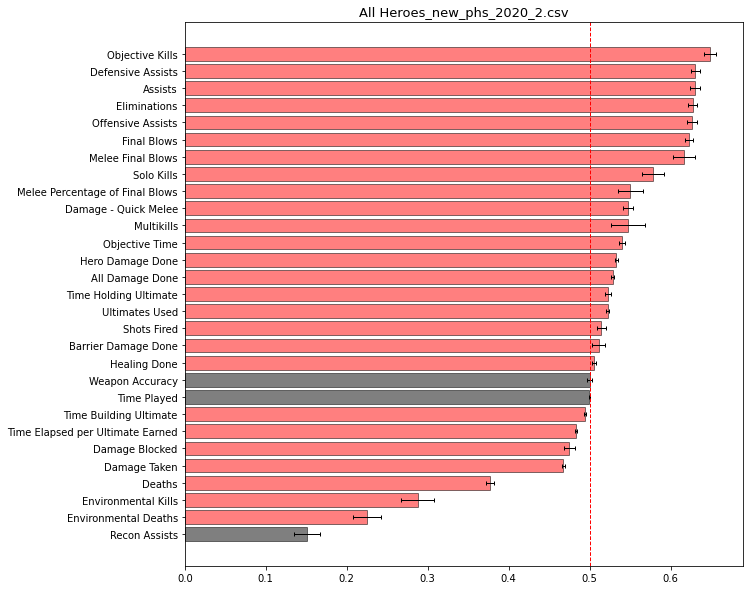

In [5]:
if target_hero == 'All Heroes':
    # t-test
    t, p = ttest_ind(df_norm_0.drop('is_map_winner', axis=1), df_norm_1.drop('is_map_winner', axis=1), equal_var=True, axis=0)

    df_norm_winner_stat = df_norm_1.drop('is_map_winner', axis=1)
    df_norm_winner_stat = df_norm_winner_stat.agg(['mean', 'count', 'std', 'sem']).transpose()
    df_norm_winner_stat['pval'] = p

    # plot winner's stats
    df_norm_winner_stat = df_norm_winner_stat.sort_values(by=['mean'], axis=0)

    color = []
    for p in df_norm_winner_stat['pval']:
        if p<0.05:
            color.append('red')
        else:
            color.append('black')

    df_norm_winner_stat['color'] = color

    if all_seasons == True:
        title = f'{target_hero}_all seasons'
    else:
        title = f'{target_hero}_{phs_name}'

    plt.figure(figsize=(10,10))
    plt.title(title, fontsize=13)
    plt.barh(df_norm_winner_stat.index.values, df_norm_winner_stat['mean'], color=color, alpha=0.5, edgecolor='black', linewidth=1, xerr=df_norm_winner_stat['sem'], error_kw={'ecolor':'black', 'elinewidth':1, 'capsize':2})
    plt.axvline(0.5, 0, 1, color='red', linestyle='--', linewidth='1') # add vertical line on 0.5 (which means winner = loser)

    # save
    if save_mode == True:
        save_path = f'./result/{target_hero}/'
        os.makedirs(save_path, exist_ok=True)
        df_norm_winner_stat.to_csv(f'{save_path}{title}.csv')
        plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## Compare individual stat

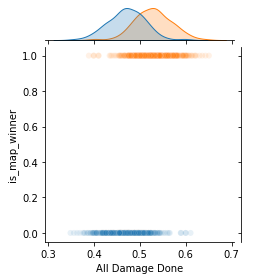

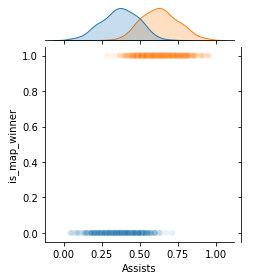

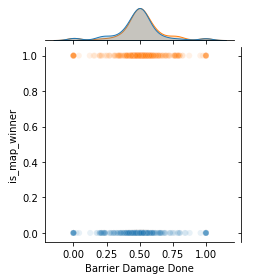

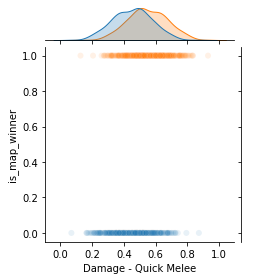

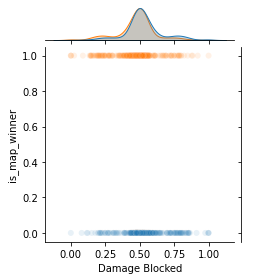

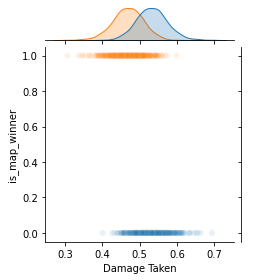

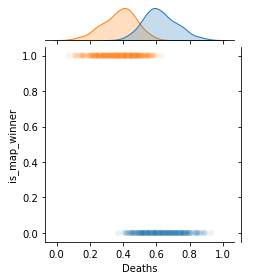

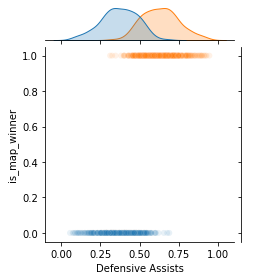

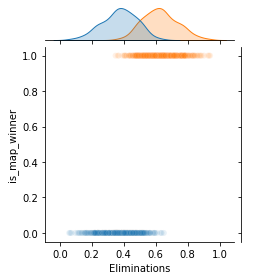

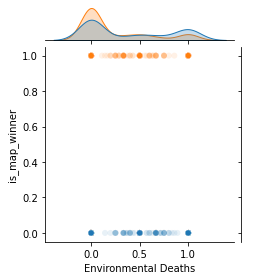

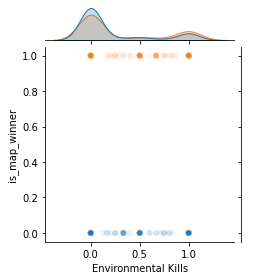

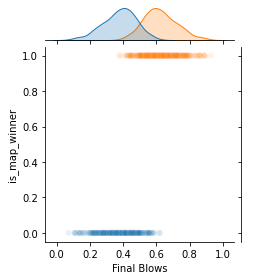

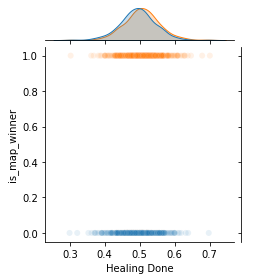

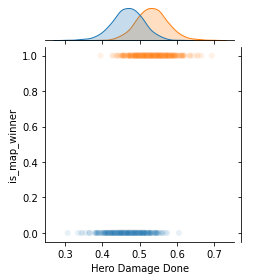

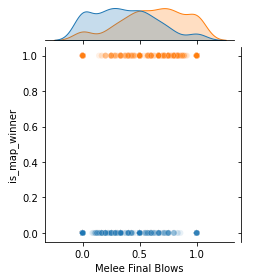

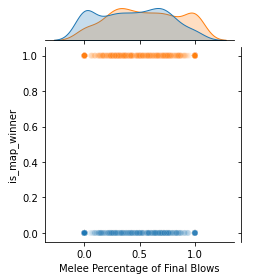

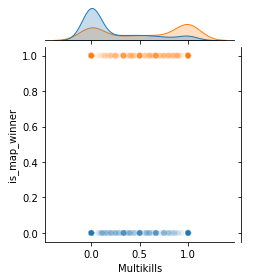

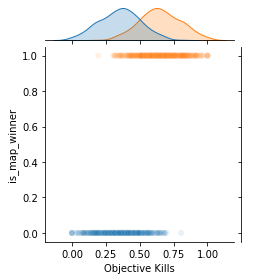

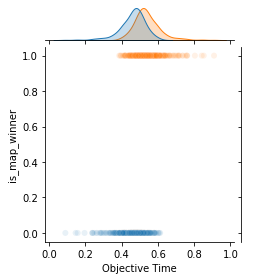

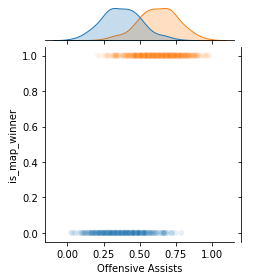

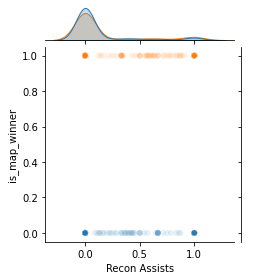

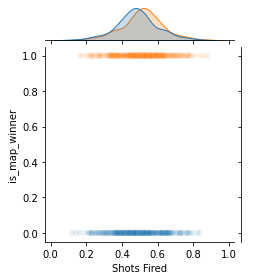

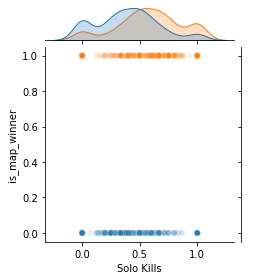

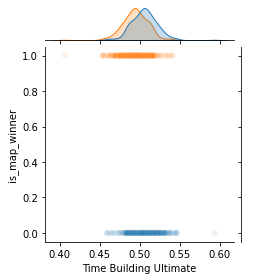

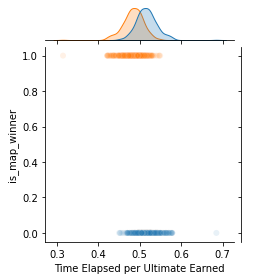

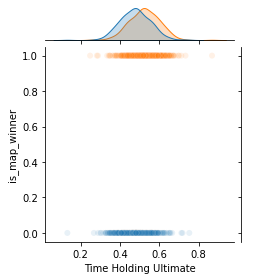

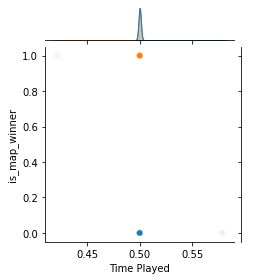

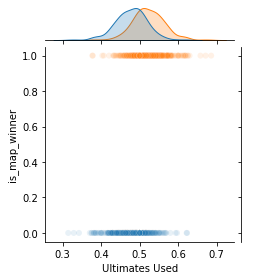

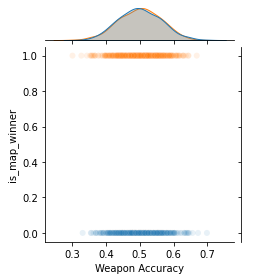

In [6]:
for f in X.columns:
    sns.jointplot(x=X[f], y=y, hue=y, height=4, legend=False, alpha=0.1)

# Data Modeling

In [14]:
# Import pakages for machine learning

from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb


## 1. Logistic Regression

(675, 29) (169, 29) (675,) (169,)
Accuracy: 0.93


cols  abs_coef
26            Time Played  0.001909
28        Weapon Accuracy  0.006378
9    Environmental Deaths  0.011892
16             Multikills  0.016337
25  Time Holding Ultimate  0.025750

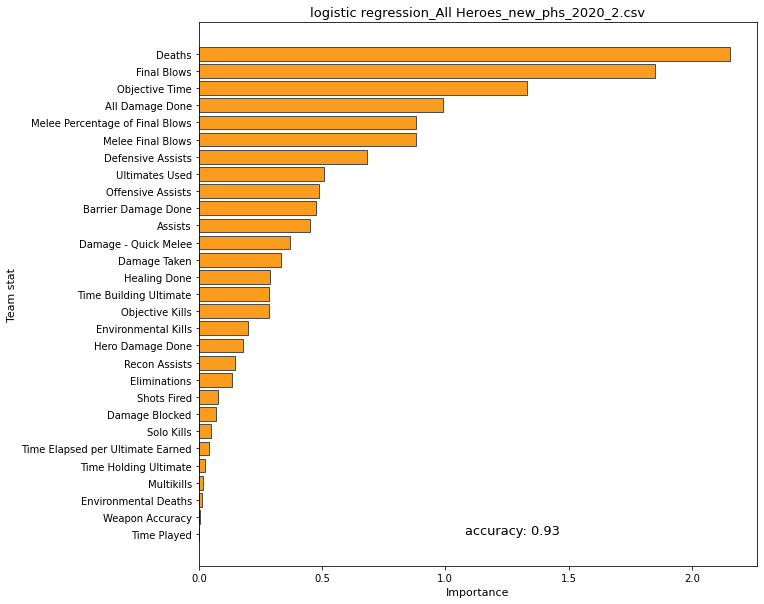

In [19]:
# Set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# # PCA
# pca = PCA(n_components=5)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Create the logistic regression model
log = LogisticRegression()
log_fit = log.fit(X_train, y_train)

# Accuracy
accuracy = log.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# Get feature coefficient
coef = log.coef_[0]
# abs_coef = coef
abs_coef = abs(coef)

# summarize feature coefficient
fea_rank_ = pd.DataFrame({'cols': feature_names, 'abs_coef': abs_coef})
fea_rank_.sort_values(by=['abs_coef'], ascending = True, inplace=True)

display(fea_rank_.head())

# Plot feature coefficient
if all_seasons == True:
    title = f'logistic regression_{target_hero}_all seasons'
else:
    title = f'logistic regression_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['abs_coef'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)

plt.text(x=max(fea_rank_['abs_coef'])/2, y=min(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
if save_mode == True:
    save_path = f'./result/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    fea_rank_.to_csv(f'{save_path}{title}.csv')
    plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## Explain the model with SHAP

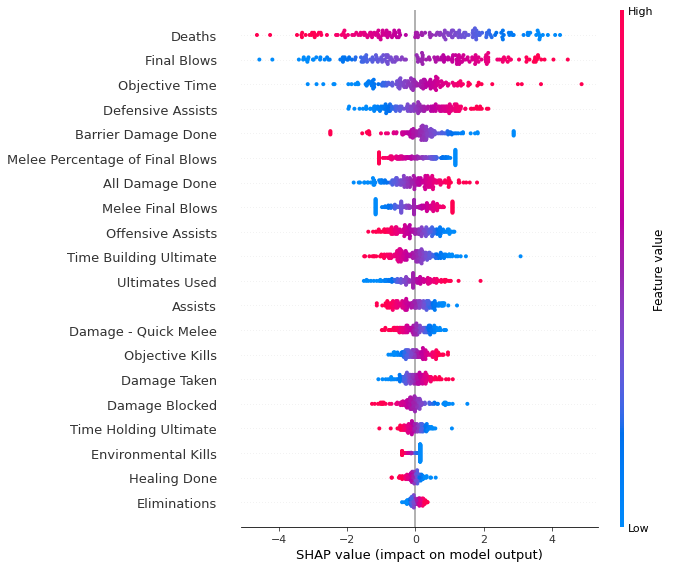

In [9]:
import shap

shap.initjs()

explainer = shap.LinearExplainer(log, X_train) # feature_perturbation='correlation_dependent'
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

Accuracy: 0.92
[False False False False False False  True  True False False False  True
 False False False  True False False  True False False False False False
 False False False False False]


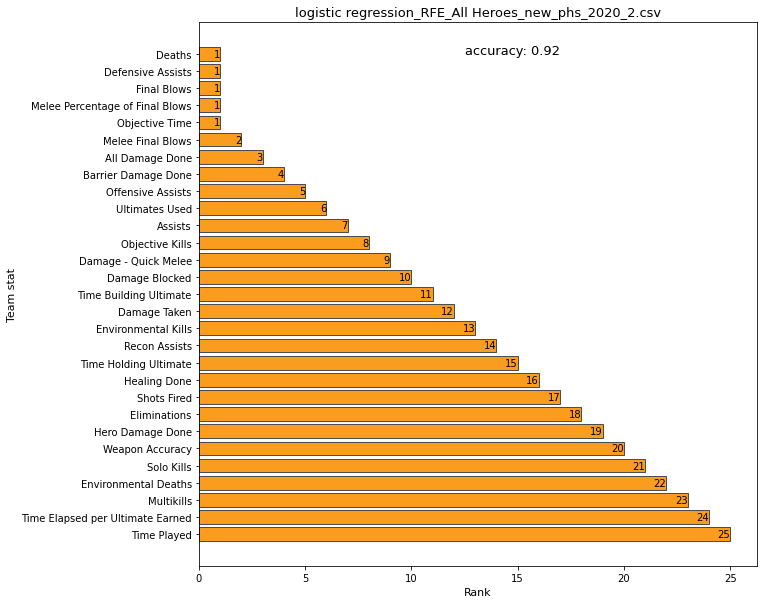

In [10]:
#Recursive Feature Elimination(RFE)

# create the RFE model
rfe = RFE(estimator=log, n_features_to_select=5)
rfe = rfe.fit(X_train, y_train)

# Accuracy
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols': feature_names, 'fea_rank': rfe.ranking_})
fea_rank_ = fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending=False)

# Plot feature importance
if all_seasons == True:
    title = f'logistic regression_RFE_{target_hero}_all seasons'
else:
    title = f'logistic regression_RFE_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['fea_rank'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Rank', fontsize=11)

for i in fea_rank_.index: # add values on bar graph
   plt.text(fea_rank_.loc[i, 'fea_rank'], fea_rank_.loc[i, 'cols'], fea_rank_.loc[i, 'fea_rank'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_rank_['fea_rank'])/2, y=max(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
if save_mode == True:
    save_path = f'./result/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    fea_rank_.to_csv(f'{save_path}{title}.csv')
    plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## 2. LightGBM classification

(540, 29) (169, 29) (540,) (169,)
[LightGBM] [Warning] num_iterations is set=5000, num_boost_round=5000 will be ignored. Current value: num_iterations=5000
Accuracy: 0.90


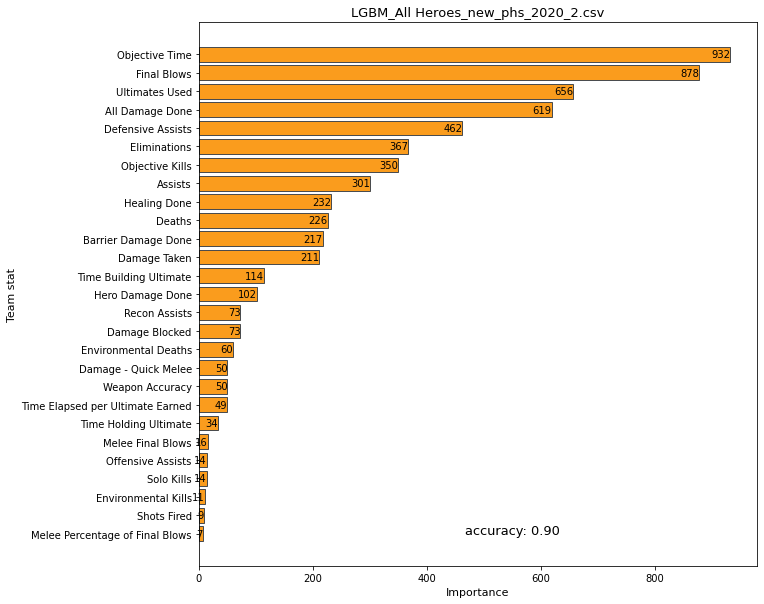

In [11]:
# LightGBM 
'''
note: https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/
'''
# set train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2) # validation set

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

feature_names = X_train.columns

# Normalize the value with StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create the lightGBM model
lgbm = lgb.LGBMClassifier(
   objective='binary', 
   boosting_type='gbdt', # gbdt(gradient boosting decision tree), rf(random forest), dart(dropouts meet multiple additive regression trees), goss(Gradient-based One-Side Sampling)
   learning_rate=0.001,
   n_estimators=500,
   num_boost_round=5000,
   )

lgbm.fit(
   X_train, y_train,
   eval_metric='binary_logloss',
   eval_set=(X_val, y_val),
   early_stopping_rounds=1000,
   verbose=False
   )

lgbm.booster_.feature_importance()

# Accuracy
accuracy = lgbm.score(X_test, y_test)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols': feature_names, 'fea_imp': lgbm.feature_importances_})
fea_imp_ = fea_imp_.loc[fea_imp_.fea_imp > 0].sort_values(by=['fea_imp'], ascending=True)

# Plot feature importance
if all_seasons == True:
    title = f'LGBM_{target_hero}_all seasons'
else:
    title = f'LGBM_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_imp_['cols'], fea_imp_['fea_imp'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Importance', fontsize=11)
for i in fea_imp_.index: # add values on bar graph
   plt.text(fea_imp_.loc[i, 'fea_imp'], fea_imp_.loc[i, 'cols'], fea_imp_.loc[i, 'fea_imp'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_imp_['fea_imp'])/2, y=min(fea_imp_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
if save_mode == True:
   save_path = f'./result/{target_hero}/'
   os.makedirs(save_path, exist_ok=True)
   fea_imp_.to_csv(f'{save_path}{title}.csv')
   plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

[LightGBM] [Warning] num_iterations is set=5000, num_boost_round=5000 will be ignored. Current value: num_iterations=5000
Accuracy: 0.89
[ True False False False False False  True  True  True False False  True
  True False False False False  True  True False False False False  True
 False False False  True False]


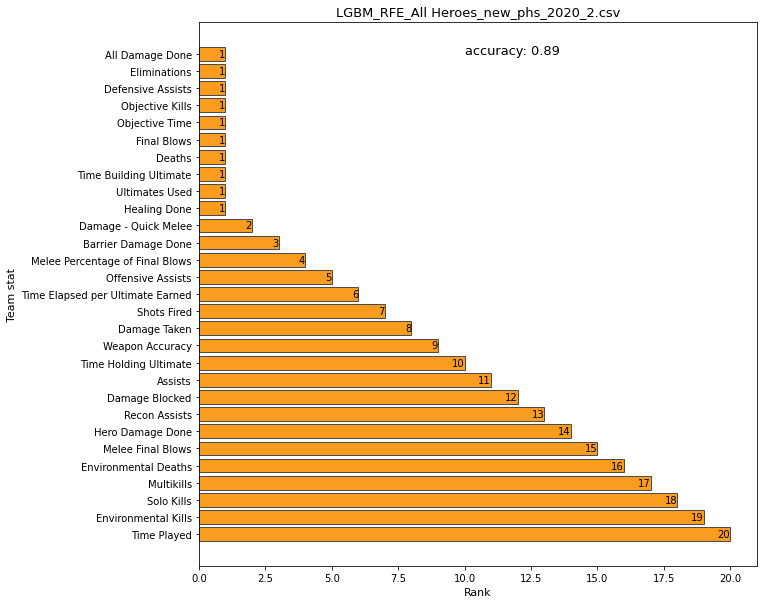

In [12]:
#Recursive Feature Elimination(RFE)

# create the RFE model
rfe = RFE(estimator=lgbm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

# Accuracy
y_pred = rfe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy = format(accuracy, '.2f')
print(f'Accuracy: {accuracy}')

# summarize the selection of the attributes
print(rfe.support_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols': feature_names, 'fea_rank': rfe.ranking_})
fea_rank_ = fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending = False)

# Plot feature importance
if all_seasons == True:
    title = f'LGBM_RFE_{target_hero}_all seasons'
else:
    title = f'LGBM_RFE_{target_hero}_{phs_name}'

plt.figure(figsize=(10,10))
plt.barh(fea_rank_['cols'], fea_rank_['fea_rank'], facecolor='#FA9C1D', alpha=1, edgecolor='#4A4C4E', linewidth=1)
plt.title(title, fontsize=13)
plt.ylabel('Team stat', fontsize=11)
plt.xlabel('Rank', fontsize=11)
for i in fea_rank_.index: # add values on bar graph
   plt.text(fea_rank_.loc[i, 'fea_rank'], fea_rank_.loc[i, 'cols'], fea_rank_.loc[i, 'fea_rank'],
   horizontalalignment='right', 
   verticalalignment='center')

plt.text(x=max(fea_rank_['fea_rank'])/2, y=max(fea_rank_.index), s=f'accuracy: {accuracy}', fontsize=13)

# Save csv and figure
if save_mode == True:
    save_path = f'./result/{target_hero}/'
    os.makedirs(save_path, exist_ok=True)
    fea_rank_.to_csv(f'{save_path}{title}.csv')
    plt.savefig(f'{save_path}{title}.png', bbox_inches='tight')

## 3. Deep neural network

(675, 29) (169, 29) (675,) (169,)
29


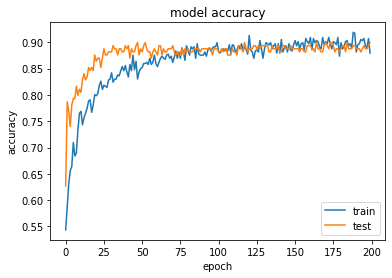

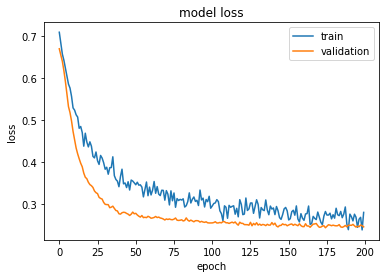

6/6 [==============================] - 0s 600us/step - loss: 0.2597 - accuracy: 0.8817


[0.25973498821258545, 0.88165682554245]

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Set train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
num_input_node = len(X_train.columns)
print(num_input_node)

# Normalize the value with StandardScaler
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# Setup a model
model = Sequential()
# 1st layer
model.add(Dense(20, activation='relu', input_shape=(num_input_node,)))
model.add(Dropout(0.3))
# 2nd layer
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.25, epochs=200, verbose=0)

# Plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Evaluate the model
eval = model.evaluate(x=X_test, y=y_test)
eval
